<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%EB%8F%99%EC%A0%81%EC%9E%90%EC%82%B0%EB%B0%B0%EB%B6%84(%2B%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8)_LAA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install yfinance
!pip install pandas_market_calendars
!pip install fredapi

In [124]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Markdown
import csv
from fredapi import Fred
import json

# 데이터 csv 내보내기 사용 여부
is_export_csv = False

# display에서 소수점 4자리까지 표현
pd.options.display.float_format = '{:.4f}'.format

# display시 DataFrame 모든 열 표시
pd.set_option('display.max_columns', None)

# 데이터 가져올 기간을 지정합니다. (오늘로부터 12개월 전)
today = datetime.today().date()
# start_date = today - timedelta(days=375)

# 오늘 날짜 string에 저장
str_today = today.strftime('### %Y-%m-%d ')

# 전략명
str_strategy = 'LAA '

# 오늘 날짜를 가져와서 파일명에 추가
today_date = today.strftime('%y%m%d')
filename = f'{today_date} {str_strategy}.xlsx'

# csv 경로 설정
output_path =  '/content/drive/MyDrive/DynamicAssetAllocation/'

# 월평균영업일수. average Monthly Business Day
MBD = 21

# 전략에 사용할 ETF 명 리스트에 담기
etf_stock = ['IWD']
etf_bond = ['IEF']
etf_gld = ['GLD']
etf_rest = ['SHY', 'QQQ']
etf_canary = ['SPY']

# 자산군 리스트 더하기, 중복 제거
etf_order = list(set(etf_stock + etf_bond + etf_gld + etf_rest + etf_canary))

# ETF 가격 추출
df_etf = yf.download(etf_order, end=today)['Adj Close']\
.sort_index(ascending=False)[etf_order].rename_axis(None, axis=0).dropna()
display(df_etf)

# 1개월씩 자르기
df_etf_monthly = df_etf[::MBD]

# DataFrame 만들기: SPY 10개월 이동평균
df_etf_spy_10mo_ma = df_etf['SPY'].rolling(window=MBD*10).mean().shift(-MBD*10+1)[::MBD].dropna()

[*********************100%%**********************]  6 of 6 completed


,SHY,IWD,QQQ,SPY,IEF,GLD
2023-11-29,81.7000,156.1400,389.8100,454.6100,93.8700,189.5400
2023-11-28,81.5400,155.6800,390.1900,454.9300,93.3800,189.2600
2023-11-27,81.3900,155.8000,389.1700,454.4800,92.9700,186.7700
2023-11-24,81.2900,156.1700,389.5100,455.3000,92.2700,185.5200
2023-11-22,81.3500,155.6400,390.0600,455.0200,92.7500,184.5600
...,...,...,...,...,...,...
2004-11-24,59.5593,41.7259,33.6839,82.2756,52.5502,45.0500
2004-11-23,59.5666,41.5268,33.3927,82.0811,52.4763,44.7500
2004-11-22,59.5739,41.4305,33.4441,81.9561,52.5256,44.9500
2004-11-19,59.5593,41.2185,33.1272,81.5670,52.4886,44.7800


In [125]:
# api key 불러오기
api_key_data = ''

with open('/content/drive/My Drive/DynamicAssetAllocation/ColabCode/api_key.json') as f:
    api_key_data = json.load(f)


## DataFrame 만들기: 미국 실업률 (ex. 08-01: 8월1일~31일 실업률 통계)
fred = Fred(api_key=api_key_data['fred'])
fred_unrate = fred.get_series('UNRATE').sort_index(ascending=False)
df_fred_unrate = pd.DataFrame(fred_unrate, columns=['unemployment rate'])

str_fred_unrate = str_today + str_strategy + "### 미국 실업률"
display(Markdown(str_fred_unrate))
display(df_fred_unrate.head(5))

if is_export_csv:
    with open(output_path + filename, 'w') as f:
        f.write(f'{str_fred_unrate}\n')
        df_fred_unrate.head(5).to_csv(f, index=True)

## DataFrame 만들기: 실업률의 12개월 이동평균
df_fred_unrate_12mo_ma = df_fred_unrate.rolling(window=12).mean().shift(-12+1)

### 2023-11-30 LAA ### 미국 실업률

,unemployment rate
2023-10-01,3.9000
2023-09-01,3.8000
2023-08-01,3.8000
2023-07-01,3.5000
2023-06-01,3.6000


,unemployment rate
2023-10-01,3.6083
2023-09-01,3.5917
2023-08-01,3.5667
2023-07-01,3.5583
2023-06-01,3.5583
...,...
1948-05-01,NaN
1948-04-01,NaN
1948-03-01,NaN
1948-02-01,NaN


In [126]:
# 인덱스 만들기
df_momentum_index = ['today/' + str(df_etf.index[0].date()), '1mo_ago/' + str(df_etf.index[MBD].date()), \
                     '3mo_ago/' + str(df_etf.index[MBD*3].date()), '6mo_ago/' + str(df_etf.index[MBD*6].date()), \
                     '12mo_ago/' + str(df_etf.index[MBD*12].date())]


## DataFrame 만들기: 1-3-6-12 개월 etf 가격
price_today = df_etf.iloc[0:1]
price_1mo = df_etf.shift(-MBD).iloc[0:1]
price_3mo = df_etf.shift(-MBD*3).iloc[0:1]
price_6mo = df_etf.shift(-MBD*6).iloc[0:1]
price_12mo = df_etf.shift(-MBD*12).iloc[0:1]

df_price = pd.concat([price_today, price_1mo, price_3mo, price_6mo, price_12mo])
df_price.index = df_momentum_index

str_etf_price = str_today + str_strategy + "### ETF 현재-1-3-6-12 개월 가격"
display(Markdown(str_etf_price))
display(df_price)

# csv에 제목 및 DataFrame 추가. 드라이브 마운트 후 해야함
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_price}\n')
    df_price.to_csv(f, index=True)

### 2023-11-30 LAA ### ETF 현재-1-3-6-12 개월 가격

,SHY,IWD,QQQ,SPY,IEF,GLD
today/2023-11-29,81.7000,156.1400,389.8100,454.6100,93.8700,189.5400
1mo_ago/2023-10-30,80.8299,145.0900,349.2000,415.5900,89.5305,185.1000
3mo_ago/2023-08-30,80.5161,158.5527,376.3152,449.4247,93.8606,180.3200
6mo_ago/2023-05-31,80.4204,147.0674,347.0110,414.8403,96.5753,182.3200
12mo_ago/2022-11-28,78.9538,151.8025,280.8066,389.7741,94.4905,161.9300


In [127]:
## DataFrame 만들기: 모멘텀 스코어 (안써도 되나 뒤 코드 처리할때 사용)
df_etf_monthly_copy = df_etf_monthly.copy(deep=True)
df_etf_momentum_score = pd.DataFrame(index=df_etf_monthly.index, columns=df_etf_monthly.columns)

for i in range(0, len(df_etf_monthly) - 12):
  ror_1mo = df_etf_monthly_copy.pct_change(-1).iloc[0]  # 1개월 수익률
  ror_3mo = df_etf_monthly_copy.pct_change(-3).iloc[0]  # 3개월 수익률
  ror_6mo = df_etf_monthly_copy.pct_change(-6).iloc[0]  # 6개월 수익률
  ror_12mo = df_etf_monthly_copy.pct_change(-12).iloc[0]  # 12개월 수익률
  df_etf_monthly_copy.drop(df_etf_monthly_copy.index[0], inplace=True)

  # 가중치 더하기
  df_etf_momentum_score.iloc[i] = ((12 * ror_1mo) + (4 * ror_3mo) + (2 * ror_6mo) + (ror_12mo)) * 100

df_etf_momentum_score.dropna(inplace=True)

str_etf_momentum_score = str_today + str_strategy + "### ETF 별 1-3-6-12 개월 Momentum Score"
'''
display(Markdown(str_etf_momentum_score))
display(df_etf_momentum_score)


# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_etf_momentum_score}\n')
    df_etf_momentum_score.head(5).to_csv(f, index=True)
'''

"\ndisplay(Markdown(str_etf_momentum_score))\ndisplay(df_etf_momentum_score)\n\n\n# csv에 제목 및 DataFrame 추가\nif is_export_csv:\n  with open(output_path + filename, 'a') as f:\n    f.write('\n')\n    f.write(f'{str_etf_momentum_score}\n')\n    df_etf_momentum_score.head(5).to_csv(f, index=True)\n"

In [128]:
## DataFrame 만들기: ETF 종목, 종목별 투자 비율
row_count = len(df_etf_momentum_score)

columns_num = [i for i in range(4)]
df_high_etf = pd.DataFrame(columns=columns_num, index=df_etf_momentum_score.index)
df_buy_ratio_etf = pd.DataFrame(columns=columns_num, index=df_etf_momentum_score.index)

portfolio_ratio = [0.25] * 4

# 마지막에 출력할 str 정의
str_unrate_spy_bad = ''
str_buy_etf = ''
str_etf_ratio = ''

for i in reversed(range(row_count)):
  # 지금 실업률이 12개월 이동평균 실업률보다 높은가?
  # 그리고 현재 SPY 가 SPY의 10개월 이동평균보다 낮은가? (둘 다 참이면 SHY(단기채) 매수)
  if (df_fred_unrate.iloc[i][0] > df_fred_unrate_12mo_ma.iloc[i][0]) and df_etf_monthly['SPY'][i] < df_etf_spy_10mo_ma[i] :
    str_unrate_spy_bad = 'True'
    df_high_etf.iloc[i] = etf_stock + etf_bond + etf_gld + [etf_rest[0]]

  # 둘 중 하나는 현재가 좋음
  else:
    str_unrate_spy_bad = 'False'
    df_high_etf.iloc[i] = etf_stock + etf_bond + etf_gld + [etf_rest[1]]

  df_buy_ratio_etf.iloc[i] = portfolio_ratio

  # 최신 데이터로 종목 뽑기
  if i == 0:
    str_buy_etf = ' '.join(df_high_etf.iloc[i].drop_duplicates())
    str_etf_ratio = str(round(df_buy_ratio_etf[df_buy_ratio_etf > 0].iloc[i].drop_duplicates().dropna()[0] * 100)) + ' %'

str_high_etf = str_today + str_strategy + "### ETF 투자 종목 선정"
display(Markdown(str_high_etf))
display(df_high_etf.head(5))

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_high_etf}\n')
    df_high_etf.head(5).to_csv(f, index=True)

### 2023-11-30 LAA ### ETF 투자 종목 선정

,0,1,2,3
2023-11-29,IWD,IEF,GLD,QQQ
2023-10-30,IWD,IEF,GLD,SHY
2023-09-29,IWD,IEF,GLD,QQQ
2023-08-30,IWD,IEF,GLD,QQQ
2023-08-01,IWD,IEF,GLD,QQQ
2023-06-30,IWD,IEF,GLD,QQQ
2023-05-31,IWD,IEF,GLD,QQQ
2023-05-01,IWD,IEF,GLD,QQQ
2023-03-30,IWD,IEF,GLD,QQQ
2023-03-01,IWD,IEF,GLD,QQQ


In [129]:
# 종목별 투자 비율
df_buy_ratio = df_buy_ratio_etf

str_buy_ratio = str_today + str_strategy + "### ETF 투자 비율"
display(Markdown(str_buy_ratio))
display(df_buy_ratio)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_buy_ratio}\n')
    df_buy_ratio.head(5).to_csv(f, index=True)

### 2023-11-30 LAA ### ETF 투자 비율

,0,1,2,3
2023-11-29,0.2500,0.2500,0.2500,0.2500
2023-10-30,0.2500,0.2500,0.2500,0.2500
2023-09-29,0.2500,0.2500,0.2500,0.2500
2023-08-30,0.2500,0.2500,0.2500,0.2500
2023-08-01,0.2500,0.2500,0.2500,0.2500
...,...,...,...,...
2006-03-23,0.2500,0.2500,0.2500,0.2500
2006-02-22,0.2500,0.2500,0.2500,0.2500
2006-01-23,0.2500,0.2500,0.2500,0.2500
2005-12-20,0.2500,0.2500,0.2500,0.2500


In [130]:
## 백테스트
monthly_column_count = df_high_etf.shape[1]
monthly_index = df_high_etf.index

# 비율대로 돈 투자
df_invest_money = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_invest_count = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_cash = pd.DataFrame(columns=['cash'], index=monthly_index)

# 초기자본
invest_cash = 10_000

for i in reversed(range(row_count)):
  row_sum = 0

  for j in range(monthly_column_count):
    if i == row_count - 1:
      row_sum = invest_cash
      break
    else:
      sel_etf = df_high_etf.iloc[i+1][j]
      row_sum += df_invest_count.iloc[i+1][j] * df_etf_monthly.iloc[i][sel_etf]

  for j in range(monthly_column_count):
    df_cash.iloc[i][0] = row_sum
    sel_etf = df_high_etf.iloc[i][j]
    sel_etf_price = df_etf_monthly.iloc[i][sel_etf]
    sel_etf_buy_count = df_cash.iloc[i][0] * df_buy_ratio.iloc[i][j] / sel_etf_price
    df_invest_count.iloc[i][j] = sel_etf_buy_count

display(Markdown(str_today + str_strategy + '### ETF 구매 개수'))
display(df_invest_count)
display(Markdown(str_today + str_strategy + '### 평가 금액'))
display(df_cash)

CAGR = str(round(((df_cash.iloc[0][0] / df_cash.iloc[-1][0]) ** (12/(row_count-1)) - 1)*100, 2))
display(Markdown(f'{str_today[1:]} {str_strategy} ## CAGR: {CAGR} %'))

### 2023-11-30 LAA ### ETF 구매 개수

,0,1,2,3
2023-11-29,71.3489,118.6792,58.7761,28.5791
2023-10-30,73.8406,119.6635,57.8797,132.5442
2023-09-29,70.6951,117.8185,62.6009,29.9576
2023-08-30,70.6802,119.3955,62.1481,29.7797
2023-08-01,69.9574,120.1770,62.7243,29.6132
...,...,...,...,...
2006-03-23,53.7276,49.3340,47.9267,73.4916
2006-02-22,54.4603,49.0492,47.5424,73.5029
2006-01-23,55.9834,48.4095,47.0050,73.2368
2005-12-20,54.4681,46.9544,51.2704,70.7746


### 2023-11-30 LAA ### 평가 금액

,cash
2023-11-29,44561.6652
2023-10-30,42854.1336
2023-09-29,42931.7030
2023-08-30,44826.1608
2023-08-01,45276.9417
...,...
2006-03-23,10486.3593
2006-02-22,10523.9818
2006-01-23,10485.8781
2005-12-20,10057.2074


## 2023-11-30  LAA  ## CAGR: 8.66 %

In [131]:
## 결과 출력
display(Markdown(str_today[1:] + str_strategy))

str_result_etf = '## 최근 실업률 > 12개월 이동평균 and 미국 SPY < 10개월 이동평균 인가?: ' + str_unrate_spy_bad
display(Markdown(str_result_etf))

str_result_buy = '## 구매할 자산: ' + str_buy_etf
display(Markdown(str_result_buy))

str_result_ratio = '## 각각 구매 비율: ' + str_etf_ratio
display(Markdown(str_result_ratio))

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_today[1:] + str_strategy}\n')
    f.write(f'{str_result_etf}\n')
    f.write(f'{str_result_buy}\n')
    f.write(f'{str_result_ratio}\n')

## 2023-11-30 LAA 

## 최근 실업률 > 12개월 이동평균 and 미국 SPY < 10개월 이동평균 인가?: False

## 구매할 자산: IWD IEF GLD QQQ

## 각각 구매 비율: 25 %

<Axes: >

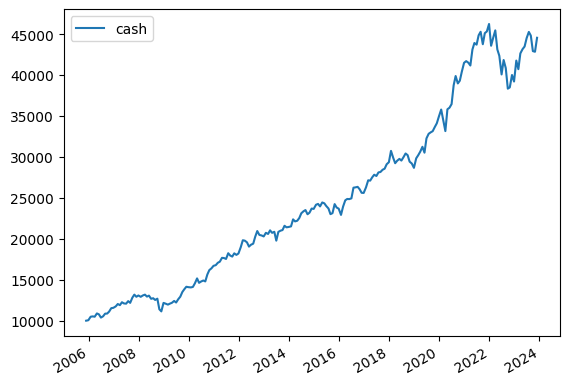

In [132]:
df_cash.plot()